In [11]:
import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [13]:
df = data.load_asset('SOLUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2022-01-01']
df.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2022-01-01,170.01,179.20,169.93,179.06,634599.39,1.105852e+08,179793,328250.16,5.720231e+07,21.0,Extreme Fear
2022-01-02,179.06,179.53,174.31,176.35,620087.38,1.095093e+08,176256,313106.42,5.529423e+07,29.0,Fear
2022-01-03,176.34,176.49,166.59,170.15,1031316.43,1.772404e+08,250131,537423.71,9.233145e+07,29.0,Fear
2022-01-04,170.14,173.93,166.47,167.72,1041332.63,1.765382e+08,264666,507127.47,8.602990e+07,23.0,Extreme Fear
2022-01-05,167.74,171.32,144.92,154.52,1659848.17,2.669799e+08,460130,775826.33,1.250144e+08,24.0,Extreme Fear


In [14]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df


In [15]:
df = add_technical_features(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-15,147.64,865014.75,Extreme Fear,0.010007,0.045833,36.653378,0.0,-31.42,5.59,3.31,-2.28,0.488251,0.001623,-1.990527,144.048571,150.423571
2022-01-16,147.98,964270.14,Extreme Fear,0.002300,0.046030,37.144767,0.0,-28.37,5.87,4.35,-1.52,0.493713,0.001653,-1.205626,145.071429,148.397143
2022-01-17,139.80,1297654.14,Extreme Fear,-0.056864,0.047179,30.928612,0.0,-30.35,11.27,0.31,-10.96,0.477513,0.001535,-0.734132,145.634286,146.229286
2022-01-18,141.22,1254337.17,Extreme Fear,0.010106,0.047617,33.023994,0.0,-26.50,8.38,2.96,-5.42,0.488271,0.001526,-0.168769,145.780000,144.336429
2022-01-19,135.25,1175171.39,Extreme Fear,-0.043194,0.044261,29.035855,0.0,-19.27,9.93,1.38,-8.55,0.493523,0.001646,-0.092659,143.457143,142.960000


In [16]:
df = data.train_test_split(df)

In [17]:
df.to_csv("tmp_df_data.csv")

In [18]:
def prep_data(df, sequence_length=30, test_size=0.2):
    # 1) include 'Close' since that's what we'll predict
    features = [
        'Close',      # ← our prediction target
        'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO',
        'buy_pressure_ratio', 'trades_per_volume', 'slope',
        'MA_7', 'MA_14'
        
    ]
    
    # 2) split numeric vs cat\egorical
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    
    # 3) combine & scale
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all.values)
    feature_names = df_all.columns.tolist()
    
    # 4) build sequences for time-series
    target_idx = feature_names.index('Close')
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        # y is the scaled Close price at time i (next day)
        y.append(data_scaled[i, target_idx])
    X, y = np.array(X), np.array(y)
    
    # 5) train/test split (preserving time order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    return (X_train, X_test, y_train, y_test), scaler

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ——— Hyperparameters (from Optuna) ———
UNITS_L0      = 160
DROPOUT_L0    = 0.0
LEARNING_RATE = 0.0007280355873484089
OPTIMIZER     = Adam(learning_rate=LEARNING_RATE)
BATCH_SIZE    = 32
MAX_EPOCHS    = 50

def train_lstm_for_asset(df, sequence_length=30, test_size=0.2):
    # … prep_data as before …
    (X_train, X_val, y_train, y_val), scaler = prep_data(
        df, sequence_length=sequence_length, test_size=test_size
    )
    
    # Build the model
    model = Sequential([
        Input(shape=X_train.shape[1:]),
        LSTM(UNITS_L0, return_sequences=False, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    
    # *** instantiate a new optimizer here, not reuse a global one ***
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=1
    )
    
    return model, scaler, history, (X_val, y_val)

# Example usage for any asset DataFrame `asset_df`:
# model, scaler, history, (X_val, y_val) = train_lstm_for_asset(asset_df)

# And to plot predictions vs actual:
# preds = model.predict(X_val).flatten()
# plt.figure(figsize=(10,5))
# plt.plot(y_val,  label='Actual Close (scaled)')
# plt.plot(preds, label='Predicted Close (scaled)')
# plt.legend()
# plt.title("LSTM Forecast (Scaled)")
# plt.show()

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0239 - val_loss: 0.0035
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.4355e-04 - val_loss: 0.0034
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.6758e-04 - val_loss: 0.0031
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.5568e-04 - val_loss: 0.0026
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.3095e-04 - val_loss: 0.0020
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.9474e-04 - val_loss: 0.0020
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.3278e-04 - val_loss: 0.0017
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.7244e-04 - val_loss: 0.0020
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.3237e-04 - val_loss: 0.0023
Epoch 12/50
29/29 ━━━━━━━━━━━━━

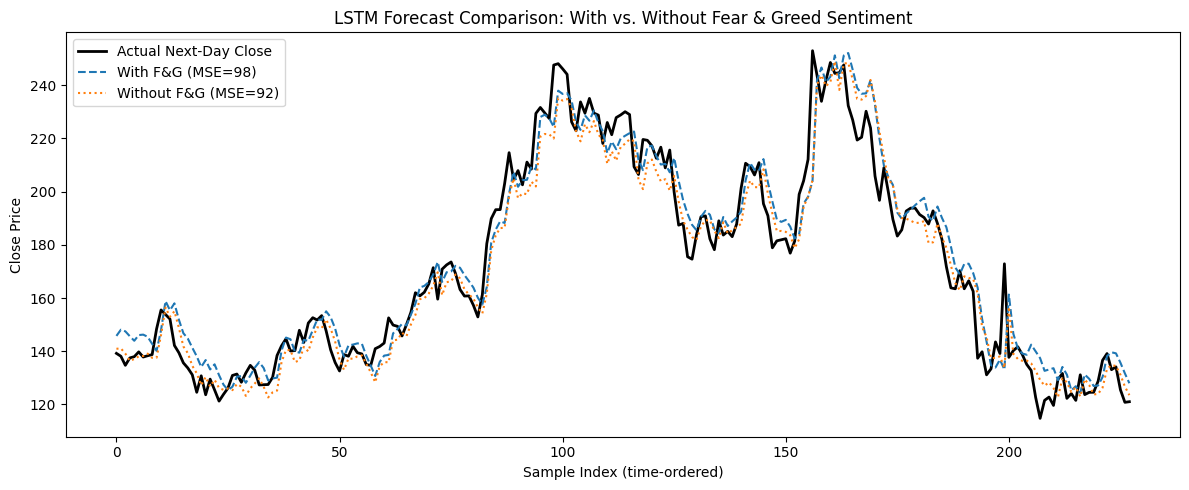

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- 1) Prepare target as next-day close ---
df['target_close'] = df['MA_7'].shift(-1)
df = df.dropna(subset=['target_close'])

# --- 2) Fit a dedicated scaler on the target only ---
scaler_y = MinMaxScaler()
scaler_y.fit(df[['target_close']])

# --- 3) Identify all F&G dummy columns ---
fg_cols = [col for col in df.columns if col.startswith("FG_cat_")]

# --- 4) Train two LSTMs via your helper function ---
# Replace `sequence_length=30` with whatever you used originally
model_with, scaler_with, hist_with, (X_val_w, y_val_w_scaled) = train_lstm_for_asset(df, sequence_length=30)

df_noFG = df.drop(columns=fg_cols)
model_without, scaler_without, hist_without, (X_val_wo, y_val_wo_scaled) = train_lstm_for_asset(df_noFG, sequence_length=30)

# --- 5) Invert scaling back to price units ---
y_val   = scaler_y.inverse_transform(y_val_w_scaled.reshape(-1, 1)).flatten()
pred_w  = scaler_y.inverse_transform(model_with.predict(X_val_w).reshape(-1, 1)).flatten()
pred_wo = scaler_y.inverse_transform(model_without.predict(X_val_wo).reshape(-1, 1)).flatten()

# --- 6) Compute MSE for both models ---
mse_with    = mean_squared_error(y_val, pred_w)
mse_without = mean_squared_error(y_val, pred_wo)

# --- 7) Plot Actual vs. Predicted (with & without F&G) ---
plt.figure(figsize=(12, 5))
plt.plot(y_val,        label=f"Actual Next-Day Close", color="black", linewidth=2)
plt.plot(pred_w,       label=f"With F&G (MSE={mse_with:.0f})", linestyle="--")
plt.plot(pred_wo,      label=f"Without F&G (MSE={mse_without:.0f})", linestyle=":")
plt.xlabel("Sample Index (time-ordered)")
plt.ylabel("Close Price")
plt.title("LSTM Forecast Comparison: With vs. Without Fear & Greed Sentiment")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0291 - val_loss: 0.0063
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.2006e-04 - val_loss: 0.0031
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.3890e-04 - val_loss: 0.0032
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.6178e-04 - val_loss: 0.0021
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.2638e-04 - val_loss: 0.0021
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.2117e-04 - val_loss: 0.0022
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.1971e-04 - val_loss: 0.0022
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.1492e-04 - val_loss: 0.0019
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.4490e-04 - val_loss: 0.0018
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.0004e-04 - val_loss: 0.0015
Epoch 12/50
29/29 ━━━━━━━━━

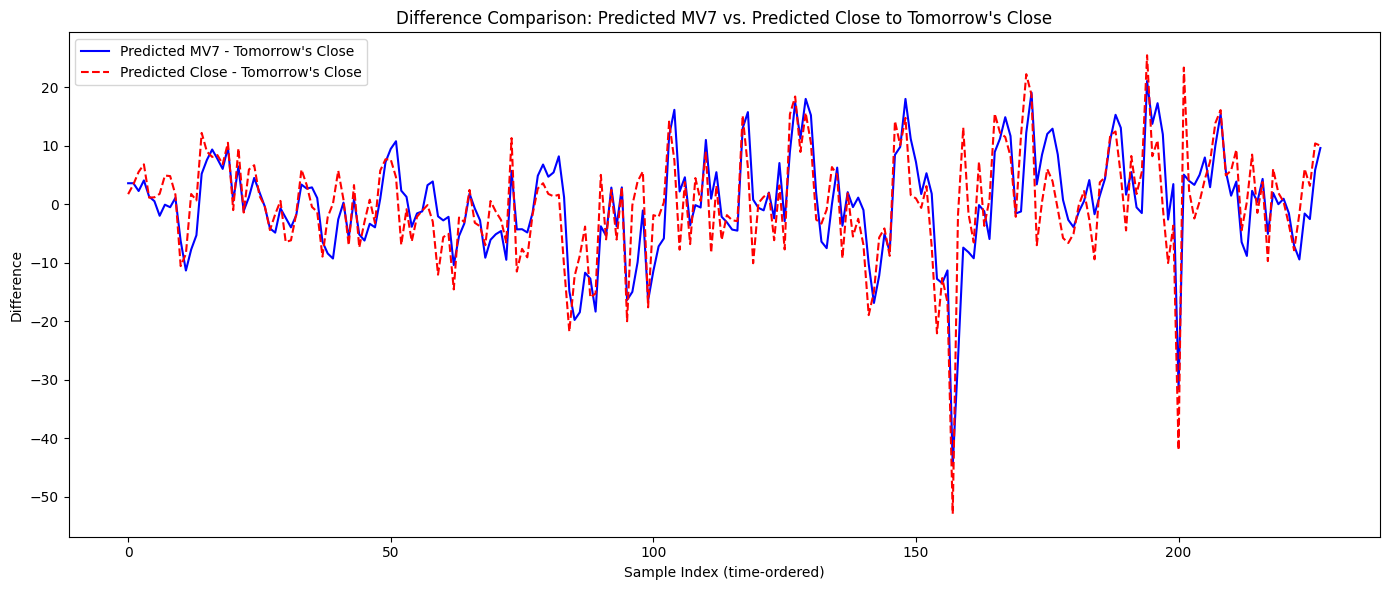

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- 1) Prepare target as next-day close ---
df['target_close'] = df['Close'].shift(-1)  # Updated: Target is next-day close
df['mv7_close'] = df['MA_7'].shift(-1)      # Updated: Target is next-day MV7
df = df.dropna(subset=['target_close', 'mv7_close'])

# --- 2) Fit a dedicated scaler on the target only ---
scaler_y = MinMaxScaler()
scaler_y.fit(df[['target_close']])

# --- 3) Identify all F&G dummy columns ---
fg_cols = [col for col in df.columns if col.startswith("FG_cat_")]

# --- 4) Train two LSTMs via your helper function ---
model_with, scaler_with, hist_with, (X_val_w, y_val_w_scaled) = train_lstm_for_asset(df, sequence_length=30)

df_noFG = df.drop(columns=fg_cols)
model_without, scaler_without, hist_without, (X_val_wo, y_val_wo_scaled) = train_lstm_for_asset(df_noFG, sequence_length=30)

# --- 5) Invert scaling back to price units ---
y_val   = scaler_y.inverse_transform(y_val_w_scaled.reshape(-1, 1)).flatten()
pred_w  = scaler_y.inverse_transform(model_with.predict(X_val_w).reshape(-1, 1)).flatten()
pred_wo = scaler_y.inverse_transform(model_without.predict(X_val_wo).reshape(-1, 1)).flatten()

# --- 6) Compute Differences (Predicted MV7 - Tomorrow's Close) and (Predicted Close - Tomorrow's Close) ---
diff_mv7 = df['mv7_close'].iloc[-len(pred_w):].values - y_val  # Predicted MV7 - Tomorrow's Close
diff_pred = pred_w - y_val                                      # Predicted Close - Tomorrow's Close

# --- 7) Compute MSE for both models ---
mse_with    = mean_squared_error(y_val, pred_w)
mse_without = mean_squared_error(y_val, pred_wo)

# --- 8) Plot Actual vs. Predicted (with & without F&G) ---
plt.figure(figsize=(14, 6))

# Plot differences
plt.plot(diff_mv7, label="Predicted MV7 - Tomorrow's Close", linestyle="-", color="blue")
plt.plot(diff_pred, label="Predicted Close - Tomorrow's Close", linestyle="--", color="red")

# Enhancing the plot
plt.xlabel("Sample Index (time-ordered)")
plt.ylabel("Difference")
plt.title("Difference Comparison: Predicted MV7 vs. Predicted Close to Tomorrow's Close")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


<Axes: >

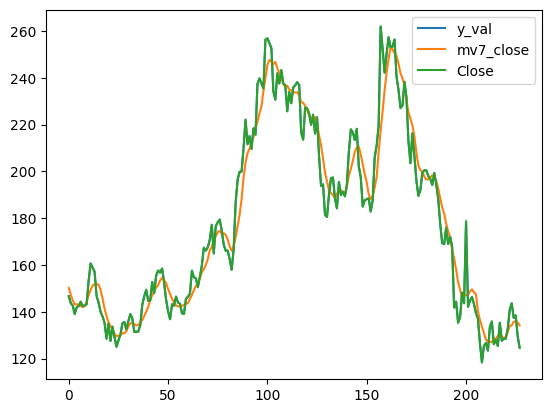

In [32]:

# --- Compute MSE for both models and naive benchmark (Today's Close as Tomorrow's Close) ---
mse_mv7 = mean_squared_error(y_val, df['mv7_close'].iloc[-len(pred_w):].values)
mse_pred = mean_squared_error(y_val, pred_w)
mse_naive = mean_squared_error(y_val, df['Close'].iloc[-len(pred_w):].values)  # Naive model MSE

# Print MSE values
print(f"MSE (Predicted MV7 - Tomorrow's Close): {mse_mv7:.4f}")
print(f"MSE (Predicted Close - Tomorrow's Close): {mse_pred:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Close): {mse_naive:.4f}")

# Plot Actual vs. Predicted Comparison
plt.figure(figsize=(14, 6))
plt.plot(y_val, label="Actual Next-Day Close", color="black", linewidth=2)
plt.plot(df['mv7_close'].iloc[-len(pred_w):].values, label=f"Predicted MV7 (MSE={mse_mv7:.4f})", linestyle="-", color="blue")
plt.plot(pred_w, label=f"Predicted Close (MSE={mse_pred:.4f})", linestyle="--", color="red")
plt.plot(df['Close'].iloc[-len(pred_w):].values, label=f"Naive Prediction (MSE={mse_naive:.4f})", linestyle=":", color="green")
plt.xlabel("Sample Index (time-ordered)")
plt.ylabel("Close Price")
plt.title("Comparison of Predicted MV7, Predicted Close, and Naive Prediction to Tomorrow's Close")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


,Close,MA_7,0
Open time,,,
2025-02-08,NaN,NaN,199.32
2025-02-09,NaN,NaN,200.47
2025-02-10,NaN,NaN,200.47
2025-02-11,NaN,NaN,197.96
2025-02-12,NaN,NaN,196.78
2025-02-13,NaN,NaN,194.25
2025-02-14,NaN,NaN,199.39
2025-02-15,NaN,NaN,194.48
2025-02-16,NaN,NaN,188.27
